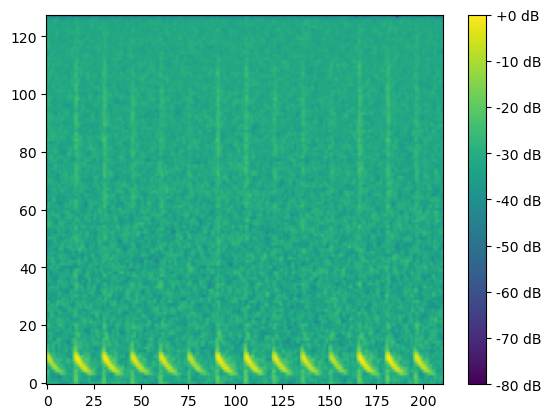

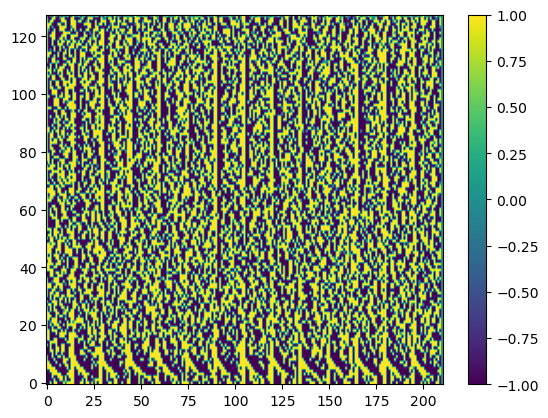

torch.Size([2, 100, 211])


In [26]:
import pickle
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
from collections import defaultdict
from torch.utils.data import random_split
import re

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikegen

import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch.nn as nn
import torch.nn.functional as F

import audio_import_giantstep as aig
import audio_import_ballroom as aib
import audio_import_syn as ais
import time
import beepy
import tonic

# Loading the datasets from disk
def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

# loaded_dataset = load_preprocessed_data('preprocessed_data_giant.pkl')
# loaded_dataset = load_preprocessed_data('preprocessed_data_giant_reduced_melbands.pkl')
#loaded_dataset = load_preprocessed_data('preprocessed_data_giant_reduced_melbands_22kres.pkl')
loaded_dataset = load_preprocessed_data('preprocessed_data_synthetic_multi_instrument.pkl')
ground_truth_max = 200
ground_truth_min = 80
MAX_OCCURRENCES = 400


# Step 1: Filter data based on ground truth range
filtered_dataset = [item for item in loaded_dataset if ground_truth_min <= item[1] <= ground_truth_max]
#filtered_dataset = filtered_dataset[:int(len(filtered_dataset)/20)]

label_dict = defaultdict(list)
for item in filtered_dataset:
    label = item[1].item()  # .item() ensures we're working with Python int, not a tensor
    label_dict[label].append(item)

# Step 3: Limit each label's items to max 100
limited_items = []
for label, items in label_dict.items():
    limited_items_for_label = items[:MAX_OCCURRENCES]
    limited_items.extend(limited_items_for_label)

# Step 4: Construct the final dataset (this will be a list, not a ConcatDataset)
filtered_dataset = limited_items

###############################################

train_data_ratio = 0.9
train_len = int(train_data_ratio * len(filtered_dataset))  # 80% for training
val_len = len(filtered_dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_dataset, [train_len, val_len])

batch_size_new = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_loader.dataset[0][0].squeeze(0).shape


example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
single_mel_db = librosa.power_to_db(single_mel, ref=np.max)
# min max normalize single_mel_db

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()


# Define a threshold for change detection
threshold = 5 * 10**-6

# Find the changes from one frame to the next
diffs = np.diff(single_mel, axis=1)

# Get event coordinates where change exceeds threshold
event_coords = np.argwhere(np.abs(diffs) >= threshold)

# Build events with [x, y, time, polarity] structure
events = []
for coord in event_coords:
    y, x = coord  # flip coordinates to match your description
    polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
    events.append([x, y, x, polarity])  # Using x as a simple stand-in for time

events = np.array(events)

# If you wish to visualize the events somehow:
# This is a simplification; you'd likely want a better visualization
event_img = np.zeros_like(single_mel)
for event in events:
    event_img[event[1], event[0]] = event[3]  # Polarities as pixel values

plt.imshow(event_img, origin='lower', aspect='auto')
plt.colorbar()
plt.show()


# Assume `mel` is your list of Mel spectrograms and `groundtruth` is your list of ground truth labels
assert len(mel) == len(groundtruth), "The lists must be of the same length"

# Pair each Mel spectrogram with its corresponding ground truth label
paired_data = list(zip(mel, groundtruth))

# Sort the paired data based on the ground truth labels
sorted_data = sorted(paired_data, key=lambda x: x[1])

# Separate the sorted pairs back into two lists
sorted_mel, sorted_groundtruth = zip(*sorted_data)

# Now you can use `sorted_mel` and `sorted_groundtruth` in place of `mel` and `groundtruth` in your code


def transform_mel(single_mel, threshold=0.0025):
    threshold = 5 * 10**-6
    frequency_cutoff = 100
    single_mel = single_mel[:frequency_cutoff]    
    diffs = np.diff(single_mel, axis=1)
    event_coords = np.argwhere(np.abs(diffs) >= threshold)

    positive_event_img = np.zeros_like(single_mel)
    negative_event_img = np.zeros_like(single_mel)

    for coord in event_coords:
        y, x = coord
        polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
        if polarity == 1:
            positive_event_img[y, x] = 1
        else:
            negative_event_img[y, x] = 1

    return positive_event_img, negative_event_img

class TransformedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        mel, groundtruth, bpm_librosa = self.dataset[idx]
        positive, negative = transform_mel(mel.squeeze(0))
        transformed_mel = np.stack([positive, negative], axis=0)
        
        sample = torch.tensor(transformed_mel).to(torch.float32)
        groundtruth = groundtruth.clone().detach().to(torch.long)
        bpm_librosa = bpm_librosa.clone().detach().to(torch.float32)
        
        return sample, groundtruth, bpm_librosa
    
    # Apply the transformation
transformed_train_dataset = TransformedDataset(train_loader.dataset)
transformed_val_dataset = TransformedDataset(val_loader.dataset)

# Create DataLoaders
batch_size_new = 64
train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size_new, shuffle=True)

mel, gt, lib = next(iter(train_loader))

example_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
print(example_mel.shape)

input_shape = example_mel.shape

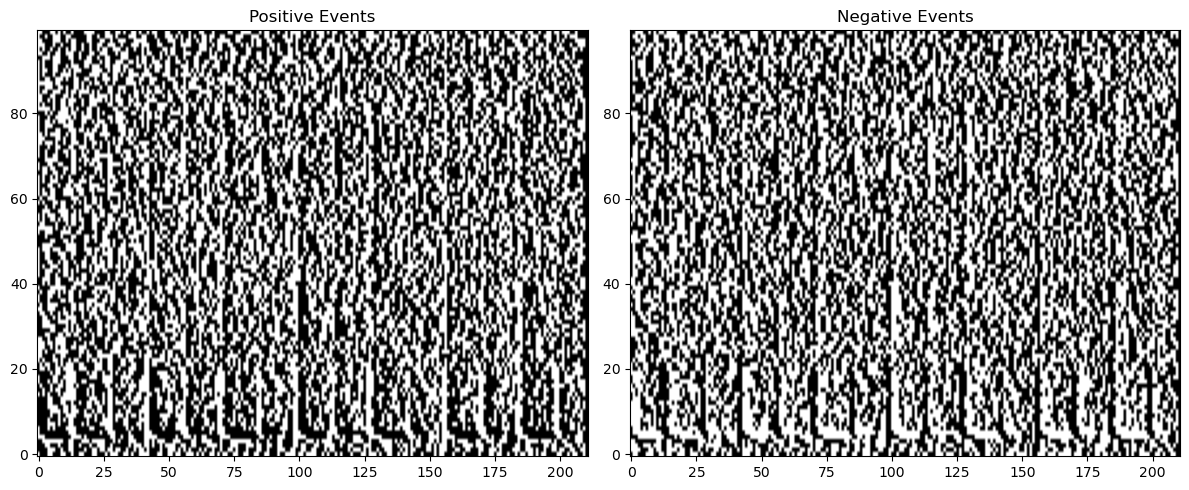

In [27]:
def plot_mel_channels(mel_tensor):
    # Ensure the tensor is on the CPU for visualization
    mel_tensor = mel_tensor.cpu()
    
    # Extract positive and negative events
    positive_events = mel_tensor[0]
    negative_events = mel_tensor[1]

    fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    
    axarr[0].imshow(positive_events, origin='lower', aspect='auto', cmap='gray')
    axarr[0].set_title('Positive Events')
    
    axarr[1].imshow(negative_events, origin='lower', aspect='auto', cmap='gray')
    axarr[1].set_title('Negative Events')
    
    plt.tight_layout()
    plt.show()

# Visualization example:
plot_mel_channels(mel[0])  # visualize the first sample from the batch

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive
import librosa
from torch.utils.data import DataLoader
import pickle
import cv2  # Importing OpenCV for the additional processing steps
from scipy.signal import convolve2d
from matplotlib.animation import FuncAnimation
import torch.nn as nn
import torch
import cv2
from IPython.display import HTML

global ani
#from skimage import exposure
def frequency_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_bands = n_bands // bin_size
    binned_mel = np.zeros((binned_bands, n_frames))
    
    for i in range(binned_bands):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[start_idx:end_idx, :]
        
        if aggregation == 'mean':
            binned_mel[i, :] = np.mean(bin_data, axis=0)
        elif aggregation == 'sum':
            binned_mel[i, :] = np.sum(bin_data, axis=0)
        elif aggregation == 'min':
            binned_mel[i, :] = np.min(bin_data, axis=0)
        elif aggregation == 'max':
            binned_mel[i, :] = np.max(bin_data, axis=0)
        elif aggregation == 'median':
            binned_mel[i, :] = np.median(bin_data, axis=0)
        elif aggregation == 'std':
            binned_mel[i, :] = np.std(bin_data, axis=0)
        elif aggregation == 'rms':
            binned_mel[i, :] = np.sqrt(np.mean(bin_data**2, axis=0))
        elif aggregation == 'low_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.1, axis=0)
        elif aggregation == 'high_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.9, axis=0)
    
    return binned_mel

def time_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_frames = n_frames // bin_size
    binned_mel = np.zeros((n_bands, binned_frames))
    
    for j in range(binned_frames):
        start_idx = j * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[:, start_idx:end_idx]
        
        if aggregation == 'mean':
            binned_mel[:, j] = np.mean(bin_data, axis=1)
        elif aggregation == 'sum':
            binned_mel[:, j] = np.sum(bin_data, axis=1)
        elif aggregation == 'min':
            binned_mel[:, j] = np.min(bin_data, axis=1)
        elif aggregation == 'max':
            binned_mel[:, j] = np.max(bin_data, axis=1)
        elif aggregation == 'median':
            binned_mel[:, j] = np.median(bin_data, axis=1)
        elif aggregation == 'std':
            binned_mel[:, j] = np.std(bin_data, axis=1)
        elif aggregation == 'rms':
            binned_mel[:, j] = np.sqrt(np.mean(bin_data**2, axis=1))
        elif aggregation == 'low_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.1, axis=1)
        elif aggregation == 'high_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.9, axis=1)
    
    return binned_mel

def compute_bandwise_thresholds(single_mel, low_factor=0.5, mid_factor=1.0, high_factor=1.5, n_windows=5):
    """
    Compute dynamic thresholds for each individual mel band of the mel spectrogram using a local window.
    
    Parameters:
    - single_mel: Mel spectrogram segment.
    - low_factor: Emphasis factor for the bass bands.
    - mid_factor: Emphasis factor for the mid-frequency bands.
    - high_factor: Emphasis factor for the high-frequency bands.
    - n_windows: Number of frames to consider on each side of the current frame for local averaging.

    Returns:
    - List of thresholds for each mel band.
    """
    n_bands, n_frames = single_mel.shape
    thresholds = np.zeros_like(single_mel)

    # Defining the indices for each category
    low_end = n_bands // 3  # First third is low
    mid_end = 2 * n_bands // 3  # Second third is mid
    window_size = n_frames // n_windows
    half_window = window_size // 2
    
    for i in range(n_bands):
        for j in range(n_frames):
            start = max(0, j - half_window)
            end = min(n_frames, j + half_window + 1)
            
            avg_energy = np.mean(single_mel[i, start:end])  # Local average energy

            # Applying the emphasis factor based on the band's category
            if i < low_end:
                thresholds[i, j] = avg_energy * low_factor
            elif i < mid_end:
                thresholds[i, j] = avg_energy * mid_factor
            else:
                thresholds[i, j] = avg_energy * high_factor
                
    return thresholds

def vertical_edge_kernel(size=5):
    kernel = np.zeros((size, size))
    mid = size // 2
    kernel[:, mid] = 1
    return kernel

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized


# def gabor_kernel(size, frequency, theta):
#     x_max = size // 2
#     x_range = np.arange(-x_max, x_max + 1)
#     y_range = np.arange(-x_max, x_max + 1)
#     x, y = np.meshgrid(x_range, y_range)
#     x_theta = x * np.cos(theta) + y * np.sin(theta)
#     y_theta = -x * np.sin(theta) + y * np.cos(theta)
#     e = -(x_theta ** 2 + y_theta ** 2) / (2 * (0.25 * size) ** 2)
#     sinusoid = np.cos(2 * np.pi * frequency * x_theta)
#     return np.exp(e) * sinusoid

def entropy(mel_spectrogram_normalized):
    eps = 1e-6
    p = mel_spectrogram_normalized.flatten() + eps
    p /= p.sum()
    p = np.clip(p, eps, 1-eps)  # Ensure no probabilities are 0 or 1
    entropy_val = -np.sum(p * np.log(p))
    if np.isnan(entropy_val) or np.isinf(entropy_val):
        return 0
    return entropy_val

def energy_distribution(mel_spectrogram_normalized):
    total_energy = np.sum(mel_spectrogram_normalized ** 2)
    if total_energy == 0:
        return np.zeros_like(mel_spectrogram_normalized.shape[0])
    energy_per_band = np.sum(mel_spectrogram_normalized ** 2, axis=1)
    distribution = energy_per_band / total_energy
    return distribution

def energy_distribution_variance(mel_spectrogram_normalized):
    distribution = energy_distribution(mel_spectrogram_normalized)
    return np.var(distribution)

def spectral_flatness_measure(mel_spectrogram_normalized):
    """Calculate the spectral flatness of a normalized mel spectrogram."""
    eps = 1e-6
    max_log_val = 10.0  # An arbitrary large value for clipping purposes
    min_log_val = -10.0  # An arbitrary small value to prevent negative infinity
    
    # Calculate geometric mean
    log_values = np.log(mel_spectrogram_normalized + eps)
    log_values = np.clip(log_values, min_log_val, max_log_val)  # Clip to avoid extreme values
    mean_log_values = np.mean(log_values, axis=1)
    geom_mean = np.exp(mean_log_values)
    
    # Calculate arithmetic mean with small positive value added to avoid division by zero
    arith_mean = np.mean(mel_spectrogram_normalized + eps, axis=1)
    
    # Calculate SFM
    sfm = geom_mean / (arith_mean + eps)
    
    # Check for NaN or infinite values and clip between 0 and 1
    sfm = np.where(np.isnan(sfm) | np.isinf(sfm), 0, sfm)
    sfm = np.clip(sfm, 0, 1)
    
    return sfm

def emphasize_dark_vertical_areas(mel_spectrogram):
    # Convert the mel spectrogram to a format suitable for OpenCV
    mel_normalized = cv2.normalize(mel_spectrogram, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Apply Gaussian blurring
    blurred = cv2.GaussianBlur(mel_normalized, (5, 5), 0)
    
    # Apply Sobel operator in the x direction
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
    
    # Convert back to the original format
    emphasized_mel = cv2.normalize(sobelx, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    
    return emphasized_mel

def average_spectral_flatness(mel_spectrogram_normalized):
    sfm = spectral_flatness_measure(mel_spectrogram_normalized)
    return np.mean(sfm)

ENTROPY_THRESHOLD = 2.0  
ENERGY_DISTRIBUTION_THRESHOLD = 2.0  
SPECTRAL_FLATNESS_THRESHOLD = 0.5   

def rate_encode(event_img, threshold=0.5, duration=50):
    spike_train = torch.zeros(event_img.shape[0], event_img.shape[1], duration)
    
    for i in range(event_img.shape[0]):
        for j in range(event_img.shape[1]):
            if event_img[i, j] > threshold:
                spike_freq = int(duration * event_img[i, j])
                spike_times = np.random.choice(duration, spike_freq, replace=True)
                spike_train[i, j, spike_times] = 1

    return spike_train

def animate(i):
    # This function updates the image content for each frame
    ax = axs[3][1]
    ax.clear()
    im = ax.imshow(spike_train[:, :, i], origin='lower', aspect='auto', cmap='gray') 
    ax.set_title(f'Rate Encoded Spike Train (time step {i})')

def plot_events(mel_idx, threshold_factor, mid_factor, high_factor, n_windows, kernel_size, gabor_frequency, line_offset):
    sample = sorted_mel[mel_idx].squeeze(0)
    global ani, spike_train, axs
    # cut off the first 10 mel bands
    single_mel = librosa.power_to_db(sample, ref=np.max, amin=1e-5, top_db=90.0)
    single_mel = librosa.db_to_power(single_mel)
    # adapative histogram equ
    # Apply adaptive histogram equalization
    #equalized_S = exposure.equalize_adapthist(single_mel)
    
    single_groundtruth = sorted_groundtruth[mel_idx]
    # min max normalize single_mel
    single_mel_normalized = (single_mel - np.min(single_mel)) / (np.max(single_mel) - np.min(single_mel))
    
    entropy_mel = entropy(single_mel_normalized)
    is_ambient = entropy_mel > ENTROPY_THRESHOLD
    print(f"Is ambient: {is_ambient}, entropy: {entropy_mel:.2f}")
            
    n_fft = 2048
    hop_size = n_fft // 4
    sample_rate = 22050
    n_frames_unbinned = single_mel.shape[1]
    total_samples = hop_size * (n_frames_unbinned - 1)
    mel_duration = total_samples / sample_rate
    print(f"Mel duration: {mel_duration:.2f} seconds")
    beat_period = 60 / int(single_groundtruth)  # time between beats in seconds
    beat_times = np.arange(line_offset, total_samples, beat_period)  # times where beats occur adjusted with line_offset
    
    single_mel_db = single_mel
    single_mel_db = np.asarray(single_mel_db)
    vertical_kernel = vertical_edge_kernel(kernel_size)
    filtered_mel = convolve2d(single_mel, vertical_kernel, mode='valid')
    
    
    frequency_bin_size = int(filtered_mel.shape[0] / 16)
    frequency_binned_mel = frequency_binning(filtered_mel, bin_size=frequency_bin_size, aggregation='rms')
    # Time Between Beats= 60 seconds / 210 beats = 0.2857 seconds/beat
    frame_duration = mel_duration / n_frames_unbinned  # Current time resolution per frame
    adjusted_beat_times = beat_times - (kernel_size - 1) * frame_duration
    adjusted_beat_frames = np.array(adjusted_beat_times / mel_duration * n_frames_unbinned, dtype=int)
    
    max_bpm_possible = 210
    time_between_beats = 60 / max_bpm_possible  # Time between beats in seconds
    desired_resolution = time_between_beats / 6  # Half of the time between beats for 210 BPM
    time_bin_size = int(desired_resolution / frame_duration)
    time_binned_mel = time_binning(frequency_binned_mel, bin_size=time_bin_size, aggregation='rms')
    binned_beat_frames = np.array(adjusted_beat_times / mel_duration * time_binned_mel.shape[1], dtype=int)
    
    time_binned_mel_normalized = (time_binned_mel) - np.min(time_binned_mel) / (np.max(time_binned_mel) - np.min(time_binned_mel))
    entropy_mel = entropy(time_binned_mel_normalized)
    is_ambient = entropy_mel < ENTROPY_THRESHOLD
    print(f"Is time binned ambient: {is_ambient}, entropy: {entropy_mel:.2f}")
    energy_variance = energy_distribution_variance(time_binned_mel_normalized) * 100
    energy_variance_base = energy_distribution_variance(single_mel_normalized) * 100

    is_energy_distributed = energy_variance < ENERGY_DISTRIBUTION_THRESHOLD
    is_energy_distributed_base = energy_variance_base < ENERGY_DISTRIBUTION_THRESHOLD
    print(f"Is energy evenly distributed time binned: {is_energy_distributed}, Energy Distribution Variance: {energy_variance:.2f}")
    print(f"Is energy evenly distributed base: {is_energy_distributed_base}, Energy Distribution Variance: {energy_variance_base:.2f}")
    
    # Calculate summarized spectral flatness
    avg_sfm = average_spectral_flatness(time_binned_mel_normalized)
    is_noiselike = avg_sfm > SPECTRAL_FLATNESS_THRESHOLD
    print(f"Is noise-like: {is_noiselike}, Average Spectral Flatness: {avg_sfm:.2f}")

    
    diffs = np.diff(time_binned_mel, axis=1)
    event_img = np.zeros_like(time_binned_mel)
    n_bands, n_frames = time_binned_mel.shape
    print(n_bands, n_frames)
    
    thresholds = compute_bandwise_thresholds(time_binned_mel, low_factor=threshold_factor, mid_factor=mid_factor, high_factor=high_factor, n_windows=n_windows)

    for i in range(n_bands):
        for j in range(n_frames - 1):  # diffs is one frame shorter
            if np.abs(diffs[i, j]) >= thresholds[i, j]:
                polarity = 1 if diffs[i, j] > 0 else -1
                event_img[i, j] = polarity
                
    positive_event_img = np.zeros_like(time_binned_mel)
    negative_event_img = np.zeros_like(time_binned_mel)

    for i in range(time_binned_mel.shape[0]):
        for j in range(time_binned_mel.shape[1] - 1):  # diffs is one frame shorter
            if np.abs(diffs[i, j]) >= thresholds[i, j]:
                polarity = 1 if diffs[i, j] > 0 else -1
                if polarity == 1:
                    positive_event_img[i, j] = 1
                else:
                    negative_event_img[i, j] = 1
                
                

    if False:
        fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
        
        #min max normalize positive_events
        positive_event_img = normalize_image(positive_event_img)
        negative_event_img = normalize_image(negative_event_img)
        
        axarr[0].imshow(positive_event_img, origin='lower', aspect='auto', cmap='gray')
        axarr[0].set_title('Positive Events')
        
        axarr[1].imshow(negative_event_img, origin='lower', aspect='auto', cmap='gray')
        axarr[1].set_title('Negative Events')
        
        # axarr[0].set_ylim(0, 1)
        # axarr[1].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
                
    # spike_train = rate_encode(time_binned_mel)
    # spike_train = spikegen.rate(torch.tensor(time_binned_mel), num_steps=5)
 
    # Plotting
    fig, axs = plt.subplots(4, 2, figsize=(20, 10))
    #plt.title("audio mel spec segment with ground truth: " + str(single_groundtruth.item()))

    im = axs[0][0].imshow(librosa.power_to_db(sample), origin='lower', aspect='auto')
    axs[0][0].set_title('Original Mel spectrogram')

    im = axs[0][1].imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
    axs[0][1].set_title(f'Mel spectrogram in dB\nGround truth: {single_groundtruth.item()}')

    # Add another subplot to show the pooled output
    im = axs[1][0].imshow(librosa.power_to_db(filtered_mel), origin='lower', aspect='auto')
    axs[1][0].set_title(f'After vertical edge kernel convolution (size={kernel_size})')
    
    # Plot Frequency binned Mel spectrogram
    im = axs[1][1].imshow(librosa.power_to_db(frequency_binned_mel), origin='lower', aspect='auto')
    axs[1][1].set_title(f'Frequency binned Mel spectrogram\nBin size={frequency_bin_size}')
    
    # Plot Temporally binned Mel spectrogram
    im = axs[2][0].imshow(librosa.power_to_db(time_binned_mel), origin='lower', aspect='auto')
    axs[2][0].set_title(f'Temporally binned Mel spectrogram\nBin size={time_bin_size}')
    
    # Plot event-based representation
    # remove last column of event_img to match the shape of time_binned_mel
    event_img = event_img[:, :-1]
    im = axs[2][1].imshow(event_img, origin='lower', aspect='auto')
    axs[2][1].set_title('Event-based representation')
    
    im = axs[3][0].imshow(positive_event_img, origin='lower', aspect='auto', cmap='gray') 
    axs[3][0].set_title('Positive Events')
    
    
    spike_data_sample = spikegen.rate(torch.tensor(positive_event_img), num_steps=100, gain=0.55)
    print(spike_data_sample.size())
    import snntorch.spikeplot as splt
    fig, ax = plt.subplots()
    anim = splt.animator(spike_data_sample, fig, ax)
    anim.save("spike_mnist_test.gif", writer='imagemagick', fps=10)
    
    fig, ax = plt.subplots()
    spike_data_sample_neg = spikegen.rate(torch.tensor(negative_event_img), num_steps=100, gain=0.55)
    anim_neg = splt.animator(spike_data_sample_neg, fig, ax)
    anim_neg.save("spike_mnist_test_neg.gif", writer='imagemagick', fps=10)
    
    
    # im = axs[3][1].imshow(spike_train, origin='lower', aspect='auto', cmap='gray') 
    # axs[3][1].set_title('Spike Train')

    # im = axs[3][1].imshow(spike_train[:, :, 0].numpy(), origin='lower', aspect='auto', cmap='gray') 
    # axs[3][1].set_title('Rate Encoded Spike Train (first time step)')
    
    # Create an animation
    #num_frames = spike_train.shape[2]
    # ani = FuncAnimation(fig, animate, frames=num_frames, interval=200, repeat=True)
    # ani.save('spike_train.gif', writer='imagemagick', fps=5)

    # im = axs[3][0].imshow(equalized_S, origin='lower', aspect='auto')
    # axs[3][0].set_title(f'temporal binning, binsize={time_bin_size}')
    
    for frame in adjusted_beat_frames:
        if frame < filtered_mel.shape[1]:
            axs[0][1].axvline(frame, color='r', linestyle='--', alpha=0.7)
            axs[1][0].axvline(frame, color='r', linestyle='--', alpha=0.7)
            axs[1][1].axvline(frame, color='r', linestyle='--', alpha=0.7)

    for beat_time in beat_times:
        frame = int(beat_time / mel_duration * n_frames_unbinned)
        if frame < n_frames_unbinned:
            axs[0][0].axvline(frame, color='r', linestyle='--', alpha=0.7)
    
    for frame in binned_beat_frames:
        if frame < time_binned_mel.shape[1]:
            axs[2][0].axvline(frame, color='r', linestyle='--', alpha=0.7)
            axs[2][1].axvline(frame, color='r', linestyle='--', alpha=0.7)


    #plt.tight_layout()
    #plt.savefig("preprocessing_process.png", dpi=400)
    plt.show()



from ipywidgets import Layout
slider_layout = Layout(width='80%')  # Adjust as needed

    
# Create sliders for various parameters
idx_slider = widgets.IntSlider(value=53, min=0, max=len(sorted_mel)-1, step=1, description='idx:', continuous_update=False, layout=slider_layout)
threshold_slider = widgets.FloatSlider(value=0.07, min=0.0, max=0.3, step=0.01, description='Low Factor:', continuous_update=True, layout=slider_layout, readout_format='.3f')
# Add sliders for the other factors
mid_factor_slider = widgets.FloatSlider(value=0.09, min=0.0, max=0.3, step=0.01, description='Mid Factor:', continuous_update=True, layout=slider_layout, readout_format='.3f')
high_factor_slider = widgets.FloatSlider(value=0.1, min=0.0, max=0.3, step=0.01, description='High Factor:', continuous_update=True, layout=slider_layout, readout_format='.3f')
n_window_slider = widgets.IntSlider(value=5, min=1, max=sorted_mel[0].squeeze(0).shape[1], step=1, description='local average window:', continuous_update=False, layout=slider_layout)
kernel_size_slider = widgets.IntSlider(value=5, min=1, max=31, step=2, description='kernel size:', continuous_update=False, layout=slider_layout)
gabor_frequency_slider = widgets.FloatSlider(value=0.6, min=0.1, max=2.0, step=0.01, description='gabor frequency:', continuous_update=False, layout=slider_layout)
offset_slider = widgets.FloatSlider(value=0.65, min=0.0, max=6.0, step=0.01, description='Line Offset (s):', continuous_update=False, layout=slider_layout)

# Adjust interactive plot function call
interactive_plot = interactive(
    plot_events,
    mel_idx=idx_slider,
    threshold_factor=threshold_slider,
    mid_factor=mid_factor_slider,
    high_factor=high_factor_slider,
    n_windows=n_window_slider,
    kernel_size=kernel_size_slider,
    gabor_frequency=gabor_frequency_slider,
    line_offset=offset_slider  # added the line_offset parameter
)

interactive_plot.layout.width = '100%'
output = interactive_plot.children[-1]
output.layout.height = '80%'
output.layout.width = '100%'
#HTML(ani.to_jshtml())
interactive_plot



interactive(children=(IntSlider(value=53, continuous_update=False, description='idx:', layout=Layout(width='80…

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive
import librosa
from torch.utils.data import DataLoader
import pickle
import cv2  # Importing OpenCV for the additional processing steps

def plot_events(mel_idx, threshold):
    frequency_cutoff = 100
    single_mel = sorted_mel[mel_idx].squeeze(0)
    single_mel = single_mel[:frequency_cutoff]
    single_groundtruth = sorted_groundtruth[mel_idx]
    
    single_mel_db = single_mel[:frequency_cutoff]
    single_mel_db = np.asarray(single_mel_db)

    threshold = threshold * 10**-6

        # Define a threshold for change detection
    # Find the changes from one frame to the next
    diffs = np.diff(single_mel, axis=1)

    # Get event coordinates where change exceeds threshold
    event_coords = np.argwhere(np.abs(diffs) >= threshold)

    # Build events with [x, y, time, polarity] structure
    events = []
    for coord in event_coords:
        y, x = coord  # flip coordinates to match your description
        polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
        events.append([x, y, x, polarity])  # Using x as a simple stand-in for time

    events = np.array(events)

    # If you wish to visualize the events somehow:
    # This is a simplification; you'd likely want a better visualization
    event_img = np.zeros_like(single_mel)
    for event in events:
        event_img[event[1], event[0]] = event[3]  # Polarities as pixel values
        
        
     #######################   
        
    baseline = cv2.blur(single_mel_db, (3, 3))  # local baseline
    refined_diffs = single_mel_db - baseline  # refined temporal contrast
    
    #refined event coords
    event_coords_refined = np.argwhere(np.abs(refined_diffs) >= threshold)
    events_refined = []
    for coord in event_coords_refined:
        y, x = coord  # flip coordinates to match your description
        polarity = 1 if refined_diffs[coord[0], coord[1]] > 0 else -1
        events_refined.append([x, y, x, polarity])  # Using x as a simple stand-in for time
    
    events_refined = np.array(events_refined)
    event_img_refined = np.zeros_like(single_mel)
    for event in events_refined:
        event_img_refined[event[1], event[0]] = event[3]
        

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 10))
    
    # Plot Mel spectrogram
    axs[0].imshow(single_mel_db, origin='lower', aspect='auto', cmap='viridis')
    axs[0].set_title(f'Mel Spectrogram - Ground Truth: {single_groundtruth}')
    
    # Plot event-based representation
    im = axs[2].imshow(event_img, origin='lower', aspect='auto')
    axs[2].set_title('Event-based representation')
    #fig.colorbar(im, ax=axs[1])
    
    im = axs[1].imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
    axs[1].set_title('Event-based representation refined')

    plt.tight_layout()
    plt.show()


from ipywidgets import Layout
slider_layout = Layout(width='80%')  # Adjust as needed

    
# Create sliders for various parameters
idx_slider = widgets.IntSlider(value=102, min=0, max=len(sorted_mel)-1, step=1, description='idx:', continuous_update=True, layout=slider_layout)
threshold_slider = widgets.FloatSlider(value=5, min=0.0, max=10, step=1, description='threshold:', continuous_update=True, layout=slider_layout, readout_format='.3f')

# Create interactive plot
interactive_plot = interactive(
    plot_events,
    mel_idx=idx_slider,
    threshold=threshold_slider,

)

interactive_plot.layout.width = '100%'
output = interactive_plot.children[-1]
output.layout.height = '80%'
output.layout.width = '80%'
interactive_plot

interactive(children=(IntSlider(value=63, description='idx:', layout=Layout(width='80%'), max=63), FloatSlider…

In [17]:
import pickle
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
from collections import defaultdict
from torch.utils.data import random_split
import re

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikegen

import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch.nn as nn
import torch.nn.functional as F

# import audio_import_giantstep as aig
# import audio_import_ballroom as aib
# import audio_import_syn as ais
import time
import beepy
import tonic

# Loading the datasets from disk
def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

# loaded_dataset = load_preprocessed_data('preprocessed_data_giant.pkl')
# loaded_dataset = load_preprocessed_data('preprocessed_data_giant_reduced_melbands.pkl')
loaded_dataset = load_preprocessed_data('preprocessed_data_giant_reduced_melbands_22kres.pkl')

ground_truth_max = 200
ground_truth_min = 80
MAX_OCCURRENCES = 500


# Step 1: Filter data based on ground truth range
filtered_dataset = [item for item in loaded_dataset if ground_truth_min <= item[1] <= ground_truth_max]
#filtered_dataset = filtered_dataset[:int(len(filtered_dataset)/20)]

label_dict = defaultdict(list)
for item in filtered_dataset:
    label = item[1].item()  # .item() ensures we're working with Python int, not a tensor
    label_dict[label].append(item)

# Step 3: Limit each label's items to max MAX_OCCURRENCES
limited_items = []
for label, items in label_dict.items():
    limited_items_for_label = items[:MAX_OCCURRENCES]
    limited_items.extend(limited_items_for_label)

# Step 4: Construct the final dataset (this will be a list, not a ConcatDataset)
filtered_dataset = limited_items
print("dataset length after filtering: ", len(filtered_dataset))

###############################################

train_data_ratio = 0.9
train_len = int(train_data_ratio * len(filtered_dataset))  # 80% for training
val_len = len(filtered_dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_dataset, [train_len, val_len])

batch_size_new = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_loader.dataset[0][0].squeeze(0).shape


example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
single_mel_db = librosa.power_to_db(single_mel, ref=np.max)

dataset length after filtering:  49472


In [18]:
# import default collate function
from torch.utils.data._utils.collate import default_collate
from scipy.signal import convolve2d

def frequency_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_bands = n_bands // bin_size
    binned_mel = np.zeros((binned_bands, n_frames))
    
    for i in range(binned_bands):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[start_idx:end_idx, :]
        
        if aggregation == 'mean':
            binned_mel[i, :] = np.mean(bin_data, axis=0)
        elif aggregation == 'sum':
            binned_mel[i, :] = np.sum(bin_data, axis=0)
        elif aggregation == 'min':
            binned_mel[i, :] = np.min(bin_data, axis=0)
        elif aggregation == 'max':
            binned_mel[i, :] = np.max(bin_data, axis=0)
        elif aggregation == 'median':
            binned_mel[i, :] = np.median(bin_data, axis=0)
        elif aggregation == 'std':
            binned_mel[i, :] = np.std(bin_data, axis=0)
        elif aggregation == 'rms':
            binned_mel[i, :] = np.sqrt(np.mean(bin_data**2, axis=0))
        elif aggregation == 'low_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.1, axis=0)
        elif aggregation == 'high_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.9, axis=0)
    
    return binned_mel


def time_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_frames = n_frames // bin_size
    binned_mel = np.zeros((n_bands, binned_frames))
    
    for j in range(binned_frames):
        start_idx = j * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[:, start_idx:end_idx]
        
        if aggregation == 'mean':
            binned_mel[:, j] = np.mean(bin_data, axis=1)
        elif aggregation == 'sum':
            binned_mel[:, j] = np.sum(bin_data, axis=1)
        elif aggregation == 'min':
            binned_mel[:, j] = np.min(bin_data, axis=1)
        elif aggregation == 'max':
            binned_mel[:, j] = np.max(bin_data, axis=1)
        elif aggregation == 'median':
            binned_mel[:, j] = np.median(bin_data, axis=1)
        elif aggregation == 'std':
            binned_mel[:, j] = np.std(bin_data, axis=1)
        elif aggregation == 'rms':
            binned_mel[:, j] = np.sqrt(np.mean(bin_data**2, axis=1))
        elif aggregation == 'low_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.1, axis=1)
        elif aggregation == 'high_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.9, axis=1)
    
    return binned_mel

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

def vertical_edge_kernel(size=5):
    kernel = np.zeros((size, size))
    mid = size // 2
    kernel[:, mid] = 1
    return kernel

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return default_collate(batch)

def energy_distribution(mel_spectrogram_normalized):
    total_energy = np.sum(mel_spectrogram_normalized ** 2)
    if total_energy == 0:
        return np.zeros_like(mel_spectrogram_normalized.shape[0])
    energy_per_band = np.sum(mel_spectrogram_normalized ** 2, axis=1)
    distribution = energy_per_band / total_energy
    return distribution

def energy_distribution_variance(mel_spectrogram_normalized):
    distribution = energy_distribution(mel_spectrogram_normalized)
    return np.var(distribution)

def compute_bandwise_thresholds(single_mel, low_factor=0.5, mid_factor=1.0, high_factor=1.5, n_windows=5):
    """
    Compute dynamic thresholds for each individual mel band of the mel spectrogram using a local window.
    
    Parameters:
    - single_mel: Mel spectrogram segment.
    - low_factor: Emphasis factor for the bass bands.
    - mid_factor: Emphasis factor for the mid-frequency bands.
    - high_factor: Emphasis factor for the high-frequency bands.
    - n_windows: Number of frames to consider on each side of the current frame for local averaging.

    Returns:
    - List of thresholds for each mel band.
    """
    n_bands, n_frames = single_mel.shape
    thresholds = np.zeros_like(single_mel)

    # Defining the indices for each category
    low_end = n_bands // 3  # First third is low
    mid_end = 2 * n_bands // 3  # Second third is mid
    window_size = n_frames // n_windows
    half_window = window_size // 2
    
    for i in range(n_bands):
        for j in range(n_frames):
            start = max(0, j - half_window)
            end = min(n_frames, j + half_window + 1)
            
            avg_energy = np.mean(single_mel[i, start:end])  # Local average energy

            # Applying the emphasis factor based on the band's category
            if i < low_end:
                thresholds[i, j] = avg_energy * low_factor
            elif i < mid_end:
                thresholds[i, j] = avg_energy * mid_factor
            else:
                thresholds[i, j] = avg_energy * high_factor
                
    return thresholds

def transform_mel(single_mel, low_factor=0.07, mid_factor=0.09, high_factor=0.1, n_windows=5):
    # Convert tensor to numpy
    single_mel = single_mel.cpu()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    single_mel = librosa.power_to_db(single_mel, ref=np.max, amin=1e-5, top_db=90.0)
    single_mel = librosa.db_to_power(single_mel)
    # adapative histogram equ
    # Apply adaptive histogram equalization
    #equalized_S = exposure.equalize_adapthist(single_mel)
    
    n_fft = 2048
    hop_size = n_fft // 4
    sample_rate = 22050
    n_frames_unbinned = single_mel.shape[1]
    total_samples = hop_size * (n_frames_unbinned - 1)
    mel_duration = total_samples / sample_rate
    
    single_mel_db = single_mel
    single_mel_db = np.asarray(single_mel_db)
    vertical_kernel = vertical_edge_kernel(7)
    filtered_mel = convolve2d(single_mel, vertical_kernel, mode='valid')
    
    
    frequency_bin_size = int(filtered_mel.shape[0] / 16)
    frequency_binned_mel = frequency_binning(filtered_mel, bin_size=frequency_bin_size, aggregation='rms')
    # Time Between Beats= 60 seconds / 210 beats = 0.2857 seconds/beat
    frame_duration = mel_duration / n_frames_unbinned  # Current time resolution per frame
    
    max_bpm_possible = 210
    time_between_beats = 60 / max_bpm_possible  # Time between beats in seconds
    desired_resolution = time_between_beats / 6  # Half of the time between beats for 210 BPM
    time_bin_size = int(desired_resolution / frame_duration)
    time_binned_mel = time_binning(frequency_binned_mel, bin_size=time_bin_size, aggregation='rms')
    
    time_binned_mel_normalized = (time_binned_mel) - np.min(time_binned_mel) / (np.max(time_binned_mel) - np.min(time_binned_mel))
    ENTROPY_THRESHOLD = 2.0
    energy_variance = energy_distribution_variance(time_binned_mel_normalized) * 100
    is_energy_evenly_distributed = energy_variance < ENTROPY_THRESHOLD
    is_valid = not is_energy_evenly_distributed
        
    diffs = np.diff(time_binned_mel_normalized, axis=1)
    n_bands, n_frames = time_binned_mel_normalized.shape
    
    thresholds = compute_bandwise_thresholds(time_binned_mel_normalized, low_factor=low_factor, mid_factor=mid_factor, high_factor=high_factor, n_windows=5)

    positive_event_img = np.zeros_like(time_binned_mel_normalized)[:, :-1]
    negative_event_img = np.zeros_like(time_binned_mel_normalized)[:, :-1]

    for i in range(n_bands):
        for j in range(n_frames - 1):  # diffs is one frame shorter
            if np.abs(diffs[i, j]) >= thresholds[i, j]:
                polarity = 1 if diffs[i, j] > 0 else -1
                if polarity == 1:
                    positive_event_img[i, j] = 1
                else:
                    negative_event_img[i, j] = 1
                      
                    
    #return positive_event_img, negative_event_img, is_valid
    return time_binned_mel_normalized, is_valid
    # return time_binned_mel_normalized

class TransformedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        mel, groundtruth, bpm_librosa = self.dataset[idx]
        #positive, negative, is_valid = transform_mel(mel.squeeze(0))
        positive, is_valid = transform_mel(mel.squeeze(0))

        
           # Prüfung auf ausreichende Entropie
        if not is_valid:
            return None
        # positive = transform_mel(mel.squeeze(0))
        transformed_mel = np.stack([positive], axis=0)
        
        sample = torch.tensor(transformed_mel).to(torch.float32)
        groundtruth = groundtruth.clone().detach().to(torch.long)
        bpm_librosa = bpm_librosa.clone().detach().to(torch.float32)
        
        return sample, groundtruth, bpm_librosa
    
    # Apply the transformation
transformed_train_dataset = TransformedDataset(train_dataset)
transformed_val_dataset = TransformedDataset(val_dataset)

# Create DataLoaders
batch_size_new = 128

train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size_new, shuffle=True, collate_fn=collate_fn)

mel, gt, lib = next(iter(train_loader))

example_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
print(example_mel.shape)

input_shape = example_mel.shape

# def plot_mel_channels(mel_tensor):
#     # Ensure the tensor is on the CPU for visualization
#     mel_tensor = mel_tensor.cpu()
    
#     # Extract positive and negative events
#     positive_events = mel_tensor[0]
#     negative_events = mel_tensor[1]

#     fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    
#     #min max normalize positive_events
#     positive_events = normalize_image(positive_events)
#     negative_events = normalize_image(negative_events)
    
#     axarr[0].imshow(positive_events, origin='lower', aspect='auto', cmap='gray')
#     axarr[0].set_title('Positive Events')
    
#     axarr[1].imshow(negative_events, origin='lower', aspect='auto', cmap='gray')
#     axarr[1].set_title('Negative Events')
    
#     # axarr[0].set_ylim(0, 1)
#     # axarr[1].set_ylim(0, 1)
    
#     plt.tight_layout()
#     plt.show()

# # Visualization example:
# plot_mel_channels(mel[0])  # visualize the first sample from the batch


torch.Size([19, 83])


In [134]:
def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

def compute_bandwise_thresholds(single_mel, low_factor=0.5, mid_factor=1.0, high_factor=1.5, n_windows=5):
    n_bands, n_frames = single_mel.shape
    thresholds = np.zeros_like(single_mel)

    # Defining the indices for each category
    low_end = n_bands // 3  # First third is low
    mid_end = 2 * n_bands // 3  # Second third is mid
    window_size = n_frames // n_windows
    half_window = window_size // 2
    
    for i in range(n_bands):
        for j in range(n_frames):
            start = max(0, j - half_window)
            end = min(n_frames, j + half_window + 1)
            
            avg_energy = np.mean(single_mel[i, start:end])  # Local average energy

            # Applying the emphasis factor based on the band's category
            if i < low_end:
                thresholds[i, j] = avg_energy * low_factor
            elif i < mid_end:
                thresholds[i, j] = avg_energy * mid_factor
            else:
                thresholds[i, j] = avg_energy * high_factor
                
    return thresholds

def transform_mel(single_mel, low_factor=0.07, mid_factor=0.09, high_factor=0.1, n_windows=5):
    # Convert tensor to numpy
    single_mel = single_mel.cpu().numpy()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    diffs = np.diff(single_mel, axis=1)
    
    thresholds = compute_bandwise_thresholds(single_mel, low_factor=low_factor, mid_factor=mid_factor, high_factor=high_factor, n_windows=n_windows)

    positive_event_img = np.zeros_like(single_mel)
    negative_event_img = np.zeros_like(single_mel)

    for i in range(single_mel.shape[0]):
        for j in range(single_mel.shape[1] - 1):  # diffs is one frame shorter
            if np.abs(diffs[i, j]) >= thresholds[i, j]:
                polarity = 1 if diffs[i, j] > 0 else -1
                if polarity == 1:
                    positive_event_img[i, j] = 1
                else:
                    negative_event_img[i, j] = 1
                    
                    
    # Define convolution layers for each quarter
    quarter_size = single_mel.shape[0] // 4
    conv_layers = [
        nn.Conv2d(1, 32, kernel_size=(quarter_size, 1), stride=1, padding=0).to(device) for _ in range(4)
    ]
    
    pos_img_tensor = torch.tensor(positive_event_img).unsqueeze(0).unsqueeze(0).float().to(device)
    neg_img_tensor = torch.tensor(negative_event_img).unsqueeze(0).unsqueeze(0).float().to(device)
    
    pos_quarters = [pos_img_tensor[:, :, i*quarter_size:(i+1)*quarter_size, :] for i in range(4)]
    neg_quarters = [neg_img_tensor[:, :, i*quarter_size:(i+1)*quarter_size, :] for i in range(4)]

    pos_outputs = []
    neg_outputs = []
    for i in range(4):
        pos_quarter_output = conv_layers[i](pos_quarters[i])
        neg_quarter_output = conv_layers[i](neg_quarters[i])
        pos_outputs.append(pos_quarter_output)
        neg_outputs.append(neg_quarter_output)

    # Concatenate the outputs back to a single tensor
    pos_img_tensor = torch.cat(pos_outputs, dim=2)
    neg_img_tensor = torch.cat(neg_outputs, dim=2)

    # For visualization purposes, we'll just take the output from the first channel of the convolution
    pos_output_np = pos_img_tensor[0, 0].cpu().detach().numpy()
    neg_output_np = neg_img_tensor[0, 0].cpu().detach().numpy()
    pos_output_np = normalize_image(pos_output_np)
    neg_output_np = normalize_image(neg_output_np)
    return pos_output_np, neg_output_np

class TransformedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        mel, groundtruth, bpm_librosa = self.dataset[idx]
        positive, negative = transform_mel(mel.squeeze(0))
        transformed_mel = np.stack([positive, negative], axis=0)
        
        sample = torch.tensor(transformed_mel).to(torch.float32)
        groundtruth = groundtruth.clone().detach().to(torch.long)
        bpm_librosa = bpm_librosa.clone().detach().to(torch.float32)
        
        return sample, groundtruth, bpm_librosa
    
    # Apply the transformation
transformed_train_dataset = TransformedDataset(train_dataset)
transformed_val_dataset = TransformedDataset(val_dataset)

# Create DataLoaders
batch_size_new = 128
train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size_new, shuffle=True)

mel, gt, lib = next(iter(train_loader))

example_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
print(example_mel.shape)

input_shape = example_mel.shape

def plot_mel_channels(mel_tensor):
    # Ensure the tensor is on the CPU for visualization
    mel_tensor = mel_tensor.cpu()
    
    # Extract positive and negative events
    positive_events = mel_tensor[0]
    negative_events = mel_tensor[1]

    fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    
    #min max normalize positive_events
    positive_events = normalize_image(positive_events)
    negative_events = normalize_image(negative_events)
    
    axarr[0].imshow(positive_events, origin='lower', aspect='auto', cmap='gray')
    axarr[0].set_title('Positive Events')
    
    axarr[1].imshow(negative_events, origin='lower', aspect='auto', cmap='gray')
    axarr[1].set_title('Negative Events')
    
    # axarr[0].set_ylim(0, 1)
    # axarr[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Visualization example:
plot_mel_channels(mel[0])  # visualize the first sample from the batch


KeyboardInterrupt: 

In [60]:
# snn temporal kernel

input_shape = train_loader.dataset[0][0].squeeze(0).shape
print(input_shape)

## 2 channel SNN

num_classes = ground_truth_max-ground_truth_min+1

class SpikingNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SpikingNet, self).__init__()

        self.surr_grad = surrogate.FastSigmoid.apply

        # First convolutional layer
        # self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2)
        self.conv1 = nn.Conv2d(2, 32, kernel_size=(35,1), stride=1, padding=(2,0))
        self.lif1 = snn.Leaky(beta=0.2)

        # Pooling
        # self.pool = nn.AvgPool2d(2)
        self.pool = nn.AvgPool2d(kernel_size=(2,1), stride=(2,1))

        # Second convolutional layer
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,1), stride=1, padding=(2,0))
        self.lif2 = snn.Leaky(beta=0.2)

        # Fully connected layer
        # self.fc1_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        # self.fc1_size = 64 * (input_shape[1] // 4) * input_shape[2]
        # After defining conv2
        self.h_out = (input_shape[1] // 2 - 2) // 2  # dividing by 2 because of two pooling layers, and subtracting 2 from the first pooling because of the kernel size and padding of conv2
        self.w_out = input_shape[2]   # width remains unchanged because pooling is only in height
        self.fc1_size = 64 * self.h_out * self.w_out * 2
        self.fc1 = nn.Linear(self.fc1_size, 1000)
        # self.fc1_size = 278528
        # self.fc1 = nn.Linear(self.fc1_size, 1000)
        self.lif3 = snn.Leaky(beta=0.2)

        # Output layer
        self.fc2 = nn.Linear(1000, num_classes)
        
        
        # Lateral inhibition
        # self.inhib = nn.Conv2d(32, 32, kernel_size=(3,1), stride=1, padding=(1,0), bias=False)
        # with torch.no_grad():
        #     self.inhib.weight[:] = 0.1
        #     self.inhib.weight[:, :, 1, 1] = -1

    def forward(self, x, mem=None):
        if mem is None:
            mem = {
                'conv1': torch.zeros(x.size(0), 32, x.size(2) + 2, x.size(3), device=x.device),
                'conv2': torch.zeros(x.size(0), 64, (x.size(2) // 2) + 3, x.size(3), device=x.device),
                'fc1': torch.zeros(x.size(0), 1000, device=x.device)
            }


        # print("Input shape:", x.shape)
        # print("After conv1:", self.conv1(x).shape)
        # print("mem['conv1'] shape:", mem['conv1'].shape)
        # First convolutional layer
        x, mem['conv1'] = self.lif1(self.conv1(x), mem['conv1'])
        # print("After conv1:", x.shape)
        # x = x + self.inhib(x) # Apply lateral inhibition
        x = self.surr_grad(x)
        x = self.pool(x)
        # print("After pool1:", x.shape)

        # Second convolutional layer
        x, mem['conv2'] = self.lif2(self.conv2(x), mem['conv2'])
        # print("After conv2:", x.shape)
        x = self.surr_grad(x)
        x = self.pool(x)

        # Flatten for the fully connected layer
        x = x.view(-1, self.fc1_size)

        # Fully connected layer
        x, mem['fc1'] = self.lif3(self.fc1(x), mem['fc1'])
        x = self.surr_grad(x)

        # Output layer
        x = self.fc2(x)
        
        return x, mem


# Define your SNN model
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingNet(input_shape, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

torch.Size([19, 83])


IndexError: tuple index out of range

In [64]:
# precious CSNN

input_shape = train_loader.dataset[0][0].squeeze(0).shape
print(input_shape)

## 2 channel SNN

num_classes = ground_truth_max-ground_truth_min+1

class SpikingNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SpikingNet, self).__init__()

        self.surr_grad = surrogate.FastSigmoid.apply
        self.apply_inhibition = False

        # First convolutional layer
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2)
        self.lif1 = snn.Leaky(beta=0.2)

        # Pooling
        self.pool = nn.AvgPool2d(2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.lif2 = snn.Leaky(beta=0.2)

        # Fully connected layer
        self.fc1_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        self.fc1 = nn.Linear(self.fc1_size, 1000)
        # self.fc1_size = 278528
        # self.fc1 = nn.Linear(self.fc1_size, 1000)
        self.lif3 = snn.Leaky(beta=0.2)

        # Output layer
        self.fc2 = nn.Linear(1000, num_classes)
        
        
               # Lateral inhibition
        self.inhib = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        with torch.no_grad():
            self.inhib.weight[:] = 0.05  
            self.inhib.weight[:, :, 1, 1] = -0.5  


    def forward(self, x, mem=None):
        if mem is None:
            mem = {
                'conv1': torch.zeros(x.size(0), 32, x.size(2), x.size(3), device=x.device),
                'conv2': torch.zeros(x.size(0), 64, x.size(2)//2, x.size(3)//2, device=x.device),
                'fc1': torch.zeros(x.size(0), 1000, device=x.device)
            }

        # First convolutional layer
        x, mem['conv1'] = self.lif1(self.conv1(x), mem['conv1'])
        x = self.surr_grad(x)
        x = self.pool(x)

        # Second convolutional layer
        x, mem['conv2'] = self.lif2(self.conv2(x), mem['conv2'])
        if self.apply_inhibition:
            x = x + self.inhib(x) # Apply lateral inhibition only if apply_inhibition is True
            x = self.surr_grad(x)
        x = self.pool(x)

        # Flatten for the fully connected layer
        x = x.view(-1, self.fc1_size)

        # Fully connected layer
        x, mem['fc1'] = self.lif3(self.fc1(x), mem['fc1'])
        x = self.surr_grad(x)

        # Output layer
        x = self.fc2(x)
        
        return x, mem


# Define your SNN model
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingNet(input_shape, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

torch.Size([19, 83])


IndexError: tuple index out of range

In [63]:
# # Training parameters
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

early_stopping = EarlyStopping(patience=5)
#train_loader = DataLoader(train_loader.dataset, batch_size=200, shuffle=True, drop_last=True)
betsch = 128
# train_loader = DataLoader(train_loader.dataset, batch_size=betsch, shuffle=True)
# train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
train_loader = DataLoader(train_loader.dataset, batch_size=betsch, shuffle=True, drop_last=True, pin_memory=True, num_workers=os.cpu_count(), collate_fn=collate_fn)

num_batches = len(train_loader)

start_time_all = time.time()

num_epochs = 30
time_steps = 3
epochs_without_inhibition = 5
epoch_losses = []
training_accuracies = []


for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()
    
    for i, (inputs, labels, _) in enumerate(train_loader):
        batch_start_time = time.time()
                
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        optimizer.zero_grad()

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)
        
        loss = criterion(outputs, target_zero_indexed)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        batch_duration = time.time() - batch_start_time
        estimated_remaining_time = batch_duration * (num_batches - (i + 1))
        
        if epoch > epochs_without_inhibition:
            model.apply_inhibition = True
        
        # Display the current loss and estimated remaining time for the epoch
        estimated_min = estimated_remaining_time/60
        
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}, Est. Remaining Time: {estimated_remaining_time:.2f} secs or {estimated_min:.1f} mins", end='\r')
        # Epoch 1/30, Batch 1/283, Loss: 4.7938, Est. Remaining Time: 7828.39 secs or 130.5 mins

    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * num_epochs
    remaining_time = (num_epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total
    training_accuracies.append(accuracy)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    beepy.beep(sound=1)  # 1 for 'coin'    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{num_epochs} epochs took {end_time/60.0:.2f} mins")


TypeError: BPMEstimator.forward() takes 2 positional arguments but 3 were given

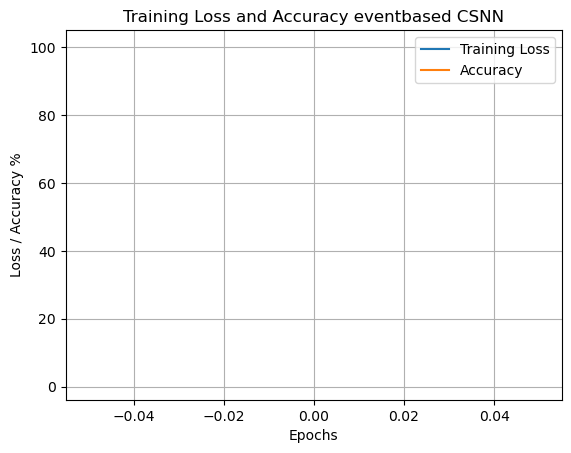

In [11]:
def min_max_normalize(arr):
    return (arr - 0) / (np.max(arr) - 0)

norm1 = min_max_normalize(np.array(epoch_losses))* 100

# If the accuracy is between 0 and 1, multiply by 100. 
# If it's already in the range 0-100, you don't need to multiply.
norm2 = np.array(training_accuracies)  # Adjust as per your data

plt.plot(norm1, label="Training Loss")
plt.plot(norm2, label="Accuracy")
plt.grid(True)
plt.title("Training Loss and Accuracy eventbased CSNN")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy %")
plt.legend()
plt.show()

In [19]:
# 1 channel CNN 
num_classes = ground_truth_max-ground_truth_min+1
class BPMEstimator(nn.Module):
    def __init__(self, input_shape):
        super(BPMEstimator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)

        # Compute the size after conv and pooling layers
        #input_shape = input_shape[1:]  # remove the channel dimension
        _, c, h, w = self.compute_intermediate_size(input_shape)
        self.flat_size = c * h * w  # new flattened size
        
        self.fc1 = nn.Linear(self.flat_size, 128)  # Using flattened size
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # Reshape data for Fully Connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

    def compute_intermediate_size(self, input_shape):
        dummy_tensor = torch.ones(1, 1, *input_shape)
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        return x.shape



def weighted_cross_entropy(output, target, amplify_factor=1.0):
    ce = nn.CrossEntropyLoss(reduction='none')(output, target)  
    
    # Get predicted class indices
    _, preds = torch.max(output, 1)
    
    # Compute absolute difference between predicted and true classes
    diffs = torch.abs(preds - target).float()
    
    # Normalize differences to get a penalty between 0 and 1, then amplify if desired
    max_possible_diff = float(num_classes - 1)  # the maximum possible difference
    penalties = (diffs / max_possible_diff) * amplify_factor
    
    # Apply penalties to the cross entropy loss values
    weighted_loss = ce * penalties
    
    return weighted_loss.mean()




model = BPMEstimator(input_shape)
print(input_shape)

num_classes = ground_truth_max-ground_truth_min+1

weights_matrix = torch.zeros(num_classes, num_classes)

for i in range(num_classes):
    for j in range(num_classes):
        weights_matrix[i, j] = abs((i + ground_truth_min) - (j + ground_truth_min))

# Normalize weights to be between 0 and 1
weights_matrix = 1 - (weights_matrix / weights_matrix.max())


# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# criterion = weighted_cross_entropy
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

torch.Size([19, 83])


In [20]:
model_load_path = "CNN_GIANTSTEP_E52_NEUROMORPHIC_4.pth"
model = BPMEstimator(input_shape)
model.load_state_dict(torch.load(model_load_path))

RuntimeError: Error(s) in loading state_dict for BPMEstimator:
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 4608]) from checkpoint, the shape in current model is torch.Size([128, 3648]).

In [12]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False
    
early_stopping = EarlyStopping(patience=8)

epochs = 80
# torch.set_num_threads(os.cpu_count()-1)
#train_loader = DataLoader(train_loader.dataset, batch_size=256, shuffle=True, drop_last=True)
num_batches = len(train_loader)
start_time = time.time()
start_time_all = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    epoch_loss = 0
    correct = 0  # Correctly predicted labels
    total = 0    # Total number of labels
    model.train()
    for batch_idx, (data, target, _) in enumerate(train_loader):
        target_zero_indexed = (target - ground_truth_min).to(device)  # Zero-indexing the labels and moving to the same device
        optimizer.zero_grad()


        # batch_size, time_steps, channels, height, width = data.unsqueeze(1).unsqueeze(1).size()
        batch_size, time_steps, channels, height, width = data.unsqueeze(1).size()
        data = data.view(batch_size, time_steps, channels, height, width)
        data = data.squeeze(1)
        outputs = model(data.float())
        loss = criterion(outputs, target_zero_indexed)  # use zero-indexed target here
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        
        # Calculating accuracy
        _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        print(f"Epoch {epoch + 1}/{epochs}, batch {batch_idx+1}/{num_batches} loss: {loss.item():.6f}", end='\r')


        
    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * epochs
    remaining_time = (epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total  # compute accuracy
    training_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    beepy.beep(sound=1)  # 1 for 'coin'
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{epochs} epochs took {end_time/60.0:.2f} mins")

Epoch 1/80, Training Loss: 4.3344, Accuracy: 3.31%, took 581.04 seconds
Estimated Total Time: 774.72 mins, Remaining Time: 765.03 mins
Epoch 2/80, Training Loss: 3.8274, Accuracy: 7.18%, took 583.44 seconds
Estimated Total Time: 777.91 mins, Remaining Time: 758.47 mins
Epoch 3/80, Training Loss: 3.6432, Accuracy: 9.06%, took 580.87 seconds
Estimated Total Time: 774.49 mins, Remaining Time: 745.45 mins
Epoch 4/80, Training Loss: 3.5392, Accuracy: 10.20%, took 577.81 seconds
Estimated Total Time: 770.42 mins, Remaining Time: 731.90 mins
Epoch 5/80, Training Loss: 3.4564, Accuracy: 11.12%, took 579.15 seconds
Estimated Total Time: 772.20 mins, Remaining Time: 723.94 mins
Epoch 6/80, Training Loss: 3.3991, Accuracy: 11.83%, took 579.62 seconds
Estimated Total Time: 772.83 mins, Remaining Time: 714.86 mins
Epoch 7/80, Training Loss: 3.3438, Accuracy: 12.71%, took 579.22 seconds
Estimated Total Time: 772.30 mins, Remaining Time: 704.72 mins
Epoch 8/80, Training Loss: 3.2932, Accuracy: 13.11%

KeyboardInterrupt: 

In [ ]:
# Save the model
# model_save_path = f"CSNN_SYNDATA_{epoch}_BPM200_ACC_{training_accuracies[-1]:.0f}.pth"
# CSNN_SYNDATA_20_BPM200_ACC_39.pth
# Model saved to CNN_SYNDATA_E5_BPM140_ACC_99.pth
# SCNN_SYNDATA_E8_BPM200_ACC_99.pth
model_save_path = f"CNN_DUALCHANNEL_GIANTSTEP_E{epoch}_NEUROMORPHIC_4.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to CNN_GIANTSTEP_E52_NEUROMORPHIC_4.pth


In [28]:
def correct_octave_error(predictions, true_values):
        # If the inputs are not iterable (lists or arrays), wrap them in a list.
    corrected_predictions = []
        
    for pred, true in zip(predictions, true_values):
        half_pred = pred / 2
        double_pred = pred * 2
        
        error_original = abs(true - pred)
        error_half = abs(true - half_pred)
        error_double = abs(true - double_pred)
        
        if error_half < error_original:
            corrected_predictions.append(half_pred)
        elif error_double < error_original:
            corrected_predictions.append(double_pred)
        else:
            corrected_predictions.append(pred)
            
    return np.array(corrected_predictions)

def is_SNN(model):
    for name, module in model.named_modules():
        if isinstance(module, snn.Leaky):
            return True
    return False

model_type = 'SCNN' if is_SNN(model) else "CNN"
time_steps = 3


# Set model to evaluation mode
model.eval()

all_predictions = []
all_confidences = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates



cnt = 0 

# No gradient is needed during evaluation/inference
#val_loader = DataLoader(transformed_val_dataset, batch_size=128, shuffle=True) # bigger batch size causes kernel crash
with torch.no_grad():
    for data, target, librosa_bpm in val_loader:
        # outputs, _ = model(data)
        outputs = model(data)
        predictions = torch.argmax(outputs, dim=1) + ground_truth_min
        all_predictions.extend(predictions.cpu().numpy()) 
        all_true_labels.extend(target.cpu().numpy())
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_confidences = np.array(all_confidences)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)

# Korrigiere die Vorhersagen für das Modell und Librosa
all_predictions_corrected = correct_octave_error(all_predictions, all_true_labels)
librosa_bpm_estimates_corrected = correct_octave_error(librosa_bpm_estimates, all_true_labels)
beepy.beep(sound=1)  # 1 for 'coin'

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def correct_octave_error(predictions, true_values):
        # If the inputs are not iterable (lists or arrays), wrap them in a list.
    corrected_predictions = []
        
    for pred, true in zip(predictions, true_values):
        half_pred = pred / 2
        double_pred = pred * 2
        
        error_original = abs(true - pred)
        error_half = abs(true - half_pred)
        error_double = abs(true - double_pred)
        
        if error_half < error_original:
            corrected_predictions.append(half_pred)
        elif error_double < error_original:
            corrected_predictions.append(double_pred)
        else:
            corrected_predictions.append(pred)
            
    return np.array(corrected_predictions)

def is_SNN(model):
    for name, module in model.named_modules():
        if isinstance(module, snn.Leaky):
            return True
    return False

model_type = 'SCNN' if is_SNN(model) else "CNN"
time_steps = 3


# Set model to evaluation mode
model.eval()

all_predictions = []
all_confidences = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates



cnt = 0 

with torch.no_grad():
    for data, target, librosa_bpm in val_loader:
        data = data.to(device)
        target_zero_indexed = target.to(device) - ground_truth_min

        mem = None
        for step in range(time_steps):
            outputs, mem = model(data, mem)

        predictions = torch.argmax(outputs, dim=1) + ground_truth_min
        confidences = torch.max(torch.softmax(outputs, dim=1), dim=1)[0].cpu().numpy()
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(target.cpu().numpy())
        all_confidences.extend(confidences)
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_confidences = np.array(all_confidences)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)

# Korrigiere die Vorhersagen für das Modell und Librosa
all_predictions_corrected = correct_octave_error(all_predictions, all_true_labels)
librosa_bpm_estimates_corrected = correct_octave_error(librosa_bpm_estimates, all_true_labels)
beepy.beep(sound=1)  # 1 for 'coin'

TypeError: BPMEstimator.forward() takes 2 positional arguments but 3 were given

In [29]:

import ipywidgets as widgets
from ipywidgets import interact_manual
from ipywidgets import Layout, interact, widgets
from IPython.display import clear_output

def visualize_based_on_threshold(threshold=0.5, tolerance=1.0):
    # Clear previous plots
    clear_output(wait=True)
    
    # Filter based on confidence threshold
    
    high_confidence_indices = np.where(all_confidences > threshold)
    filtered_predictions = all_predictions[high_confidence_indices]
    filtered_true_labels = all_true_labels[high_confidence_indices]
    filtered_accuracy = np.mean(np.abs(filtered_true_labels - filtered_predictions) <= tolerance) * 100
    correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
    correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
    accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
    print(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")
    print(f"cnt  {len(filtered_predictions)}/{len(all_true_labels)}")
    # Update your scatter plot or any other visualizations using high_confidence_indices
    plt.figure(figsize=(8, 8))
    plt.scatter(all_true_labels[high_confidence_indices], all_predictions[high_confidence_indices], color='red', alpha=0.3)
    plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
    plt.axhline(y=0, color='k', linestyle='--')
    plt.title(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {filtered_accuracy:.2f}%\n Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%\n confidence threshold: {threshold}\n after {len(epoch_losses)} epochs")
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    

    plt.show()
       


# Define and display slider
threshold_slider = widgets.FloatSlider(value=0.5, min=0, max=0.99, step=0.01, description='Confidence Threshold:')
tolerance_slider = widgets.IntSlider(value=1, min=1, max=30, step=1, description='Tolerance:')
widgets.interactive(visualize_based_on_threshold, threshold=threshold_slider, tolerance=tolerance_slider)


interactive(children=(FloatSlider(value=0.5, description='Confidence Threshold:', max=0.99, step=0.01), IntSli…

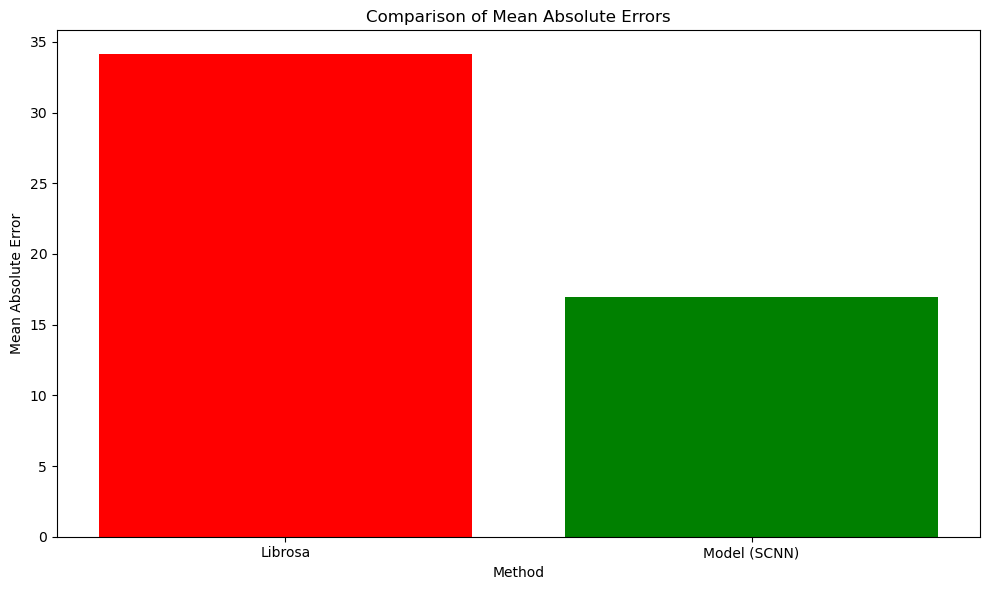

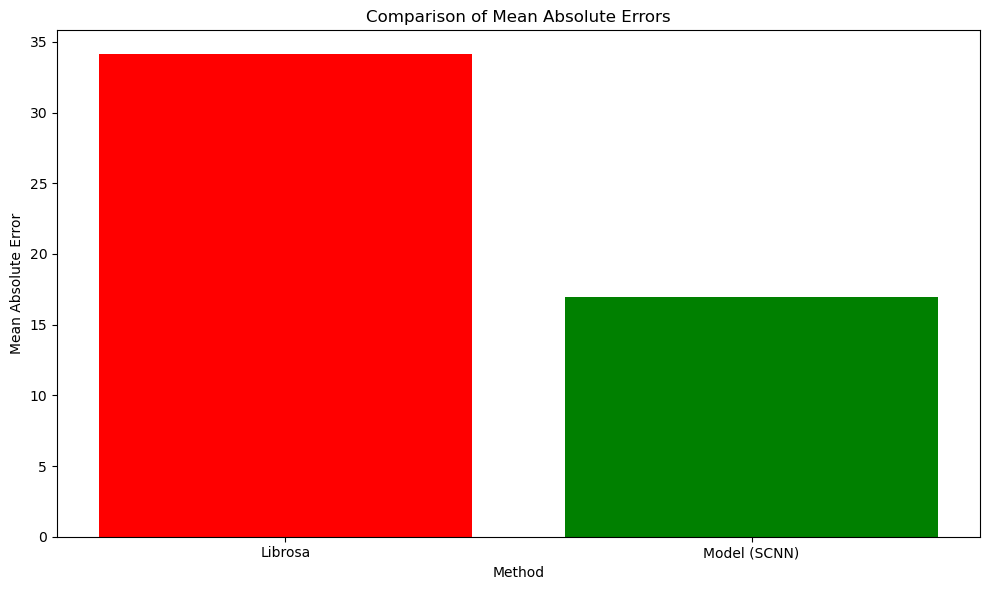

In [ ]:

# Calculate Mean Absolute Errors
model_mae = np.mean(np.abs(all_true_labels - all_predictions))
librosa_mae = np.mean(np.abs(all_true_labels - librosa_bpm_estimates))
model_corrected_mae = np.mean(np.abs(all_true_labels - all_predictions_corrected))

# Plot Mean Absolute Errors
model_label = f'Model ({model_type})'
labels = ['Librosa', model_label]
errors = [librosa_mae, model_mae]

plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['red', 'green'])
plt.xlabel('Method')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Errors')
plt.tight_layout()
plt.show()

In [ ]:
# Extract all ground truth labels from transformed_train_dataset
all_gt_labels = [label for _, label, _ in transformed_train_dataset]

# Convert the list of labels into a tensor
all_gt_tensor = torch.tensor(all_gt_labels, dtype=torch.int)



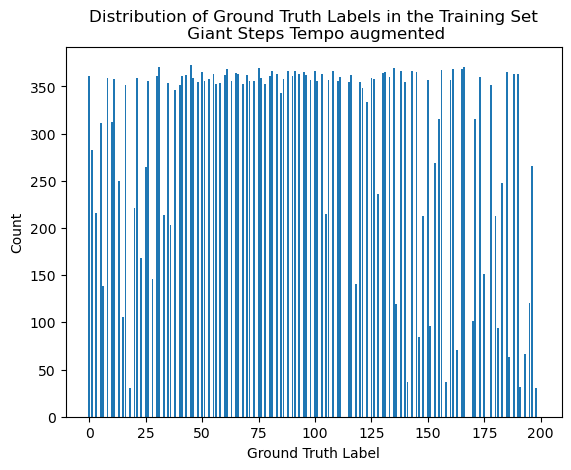

In [ ]:
# Compute histogram
hist = torch.histc(all_gt_tensor.float(), bins=200, min=80, max=200)

# Plot
plt.bar(range(200), hist.numpy())
plt.xlabel('Ground Truth Label')
plt.ylabel('Count')
plt.title('Distribution of Ground Truth Labels in the Training Set\n Giant Steps Tempo augmented')
plt.show()

264704


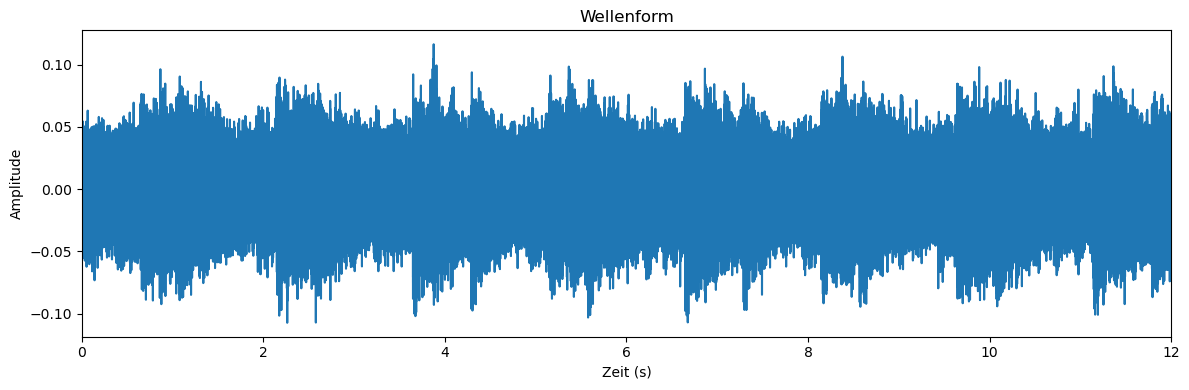

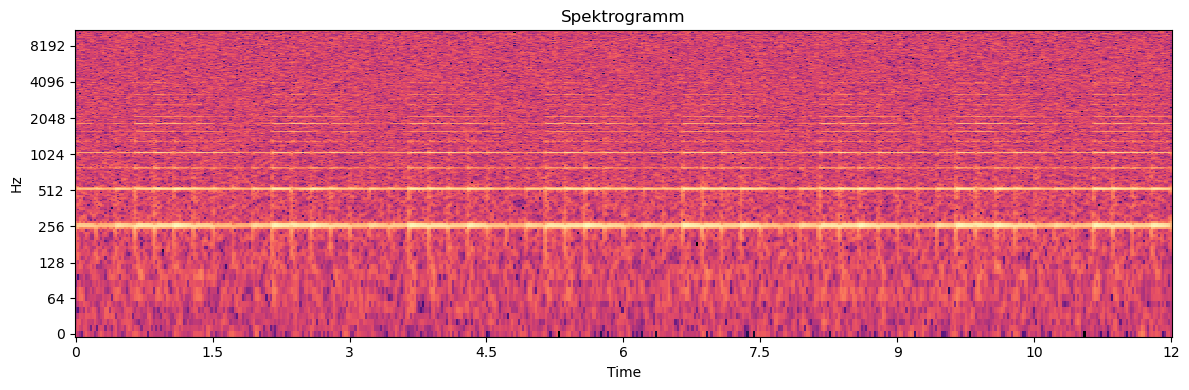

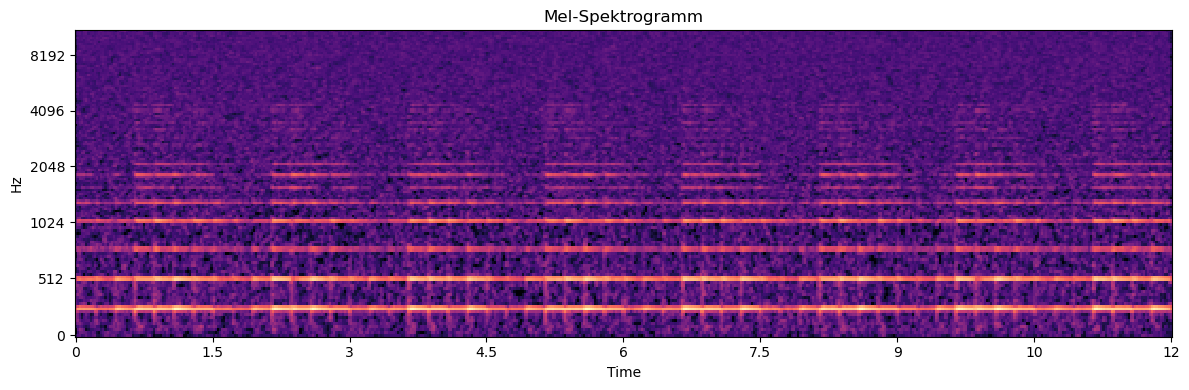

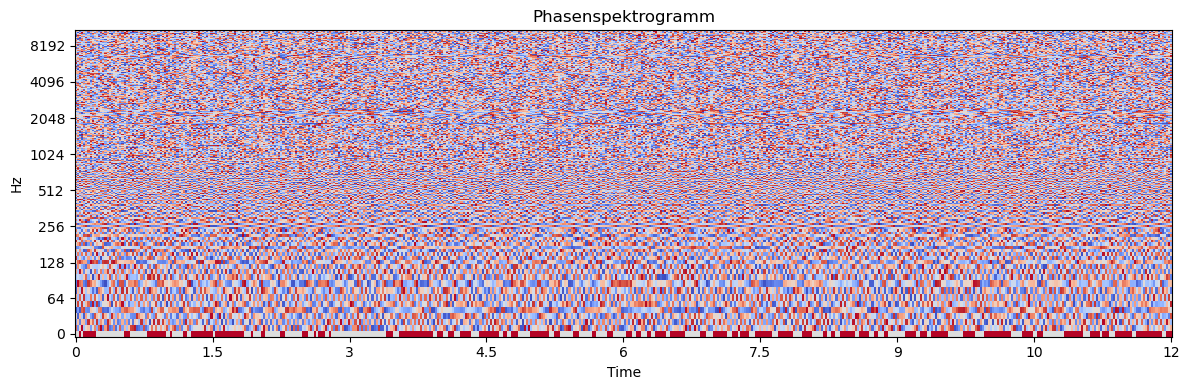

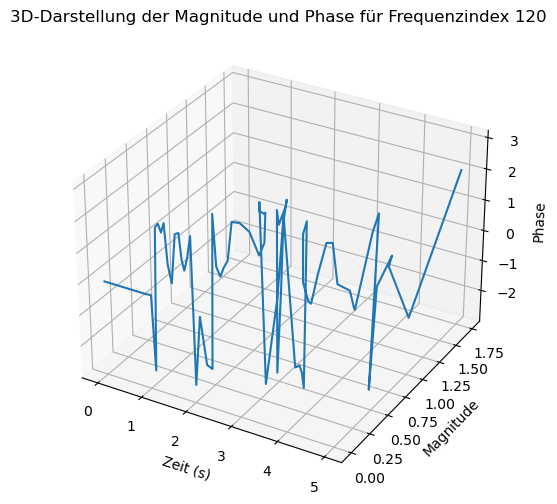

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Audio laden
y, sr = librosa.load('sample.wav', sr=22050)  # sr=None behält die ursprüngliche Abtastrate bei
print(len(y))
# Wellenform visualisieren
plt.figure(figsize=(12, 4))
plt.xlim(0, len(y)/sr)
plt.plot(np.linspace(0, len(y)/sr, num=len(y)), y)
plt.title('Wellenform')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Spektrogramm visualisieren
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
#plt.colorbar(format='%+2.0f dB')
plt.title('Spektrogramm')
plt.tight_layout()
plt.show()

# Mel-Spektrogramm visualisieren
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spektrogramm')
plt.tight_layout()
plt.show()
# STFT des Signals berechnen
stft_result = librosa.stft(y)

# Magnitude und Phase extrahieren
magnitude = np.abs(stft_result)
phase = np.angle(stft_result)

# Phasenspektrogramm visualisieren
plt.figure(figsize=(12, 4))
librosa.display.specshow(phase, sr=sr, x_axis='time', y_axis='log')
#plt.colorbar()
plt.title('Phasenspektrogramm')
plt.tight_layout()
plt.show()

# Audio laden
y, sr = librosa.load('sample_real.wav', sr=22050*2)

# 5-Sekunden-Ausschnitt extrahieren
start_sample = 0
seconds = 1
end_sample = start_sample + seconds * sr
y_segment = y[start_sample:end_sample]

# STFT mit größerem Fenster berechnen
stft_result = librosa.stft(y_segment, n_fft=2048, hop_length=512)

# Magnitude und Phase extrahieren
magnitude = np.abs(stft_result)
phase = np.angle(stft_result)

# Einfache Glättung auf die Magnitude anwenden
window_size = 5
smoothed_magnitude = np.convolve(magnitude[index, :], np.ones(window_size)/window_size, mode='valid')

# Zeitvektor für den Ausschnitt erstellen (angepasst für Glättung)
times = np.linspace(0, 5, num=len(smoothed_magnitude))

# Wählen Sie eine Frequenzkomponente zum Darstellen (z. B. den 10. Index)
index = 120

# Daten für die gewählte Frequenzkomponente extrahieren
# selected_phase = phase[index, :len(smoothed_magnitude)]
selected_phase = phase[index,:len(smoothed_magnitude)]

# 3D-Plot erstellen
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(times, smoothed_magnitude, selected_phase)
ax.set_xlabel('Zeit (s)')
ax.set_ylabel('Magnitude')
ax.set_zlabel('Phase')
ax.set_title(f'3D-Darstellung der Magnitude und Phase für Frequenzindex {index}')

plt.show()
